In [6]:
from __future__ import print_function
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys
from IPython.display import display, Image
from six.moves import cPickle as pickle
from scipy.misc import imread, imsave, imresize
from scipy import signal
from skimage import data as dt, transform as transform, io
from PIL import Image as Image1, ImageEnhance
import pandas as pd
%matplotlib inline

In [16]:
data_root = '.'

img_rows, img_cols = 62, 62

#path = os.path.join(data_root ,"CAX_Superhero_Train") 
path = os.path.join(data_root ,"CAX_Superhero_Test") 

### Images preprocessing ###

for filename in os.listdir(path):
    files = os.listdir(os.path.join(path,filename))
    
    data = np.zeros((len(files), img_rows,img_cols,3))

    
    for i, file in enumerate(files):
        
        filepath = os.path.join(path,filename,files[i])
        #core = os.path.join(data_root,'resized_dataset_train',filename)
        core = os.path.join(data_root,'resized_dataset_test',filename)
        newName = os.path.join(core,files[i])
        if not os.path.exists(core):
            os.makedirs(core)
        if not os.path.exists(newName):    
            image = dt.imread(filepath)
            imageResized = transform.resize(image, (img_rows,img_cols))
            if imageResized.shape == data[i].shape:
                data[i] = imageResized
                io.imsave(newName, imageResized)
                #print(newName)
                
                
#root = os.path.join(data_root,'resized_dataset_train')
root = os.path.join(data_root,'resized_dataset_test')

data_folders = [
    os.path.join(root,d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root,d))
]

In [17]:
image_size = 62
pixel_depth = 255.0

def load_hero(folder):
    # Load data for single hero label
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size,image_size,3),dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder,image)
        try:
            image_data = ((io.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth)
            if image_data.shape != (image_size,image_size,3):
                 raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :,:] = image_data
            num_images += 1
        except (IOError,ValueError) as e:
            print('Could not read:',image_file,":",e,'- it\'s ok, skipping.')
    dataset = dataset[0:num_images,:,:,:]
    print('Full dataset tensor:',dataset.shape)
    print('Mean:',np.mean(dataset))
    print('Standard deviation:',np.std(dataset))
    return dataset

def maybe_pickle(data_folders, force =False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder+'.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_hero(folder)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exaception as e:
                print('Unable to save data to', set_filename,":",e)
    return dataset_names

datasets = maybe_pickle(data_folders)

Pickling ./resized_dataset_test/CAX_Superhero_Test.pickle.
Full dataset tensor: (3375, 62, 62, 3)
Mean: 0.17054774
Standard deviation: 0.36937064


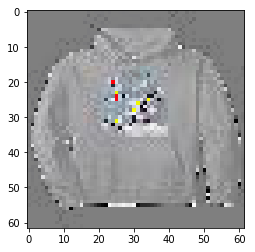

In [18]:
pickle_file = datasets[0]
with open(pickle_file,'rb') as f:
    letter_set = pickle.load(f) #unppickle
    sample_idx = 23
    sample_image = letter_set[sample_idx,:,:,:]
    plt.figure()
    plt.imshow(sample_image)

In [12]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size,img_size,3), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None,None
    return dataset, labels

def merge_datasets(pickle_files):
    num_classes = len(pickle_files)
    
    path = os.path.join('.','resized_dataset_train')
    t = os.listdir(path)

    train_size = 0
    
    for i in t:
        if os.path.isdir(os.path.join(path,i)):
            train_size += len(os.listdir(os.path.join(path,i)))
            
    train_dataset, train_labels = make_arrays(train_size, image_size)
    
    start_train,end_train = 0,0
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                np.random.shuffle(letter_set)
                end_train += len(letter_set)
                
                train_dataset[start_train:end_train, :, :, :] = letter_set
                train_labels[start_train:end_train] = label
                start_train = end_train
                
               
        except Exception as e:
            print('Unable to process data from', pickle_file, ':',e)
            raise
    
    return train_dataset,train_labels


train_dataset,train_labels = merge_datasets(datasets)


In [13]:
print('Training: ', train_dataset.shape, train_labels.shape)

Training:  (5430, 62, 62, 3) (5430,)


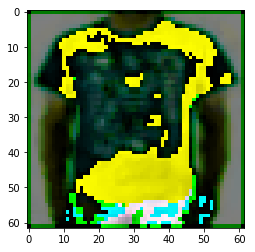

0


In [19]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)

plt.imshow(signal.medfilt(train_dataset[0]), interpolation='nearest')
plt.show() 
print(train_labels[0])
    

In [20]:
import csv
def createLabelForTest(datasets):
    
    labelDict = {'ant_man':0,'aqua_man':1,'avengers':2,'bat_man':3,'black_panther':4,'captain_america':5,'cat_woman':6,'ghostrider':7,
                'hulk':8,'iron_man':9,'spider_man':10,'super_man':11}
    
    with open('./Superhero_3375_SampleSubmission.csv', 'r') as csvFile:
        
        reader = list(csv.reader(csvFile))
        length = len(reader)-1
        test_dataset = np.ndarray((length,62,62,3), dtype=np.float32)
        test_labels = np.ndarray(length, dtype=np.int32)
        
        with open(datasets[0], 'rb') as f:
                letter_set = pickle.load(f)
                test_dataset = letter_set
        f.close()
        
        for i,row in enumerate(reader):
            if(i==0): 
                continue
            test_labels[i-1] = labelDict[row[1]]
            

        csvFile.close()
        
        return test_dataset,test_labels

test_dataset,test_labels = createLabelForTest(datasets)

Training:  (3375, 62, 62, 3) (3375,)


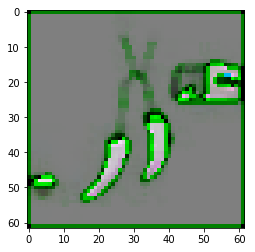

0


In [21]:
print('Training: ', test_dataset.shape, test_labels.shape)
test_dataset, test_labels = randomize(test_dataset, test_labels)

plt.imshow(signal.medfilt(test_dataset[0]), interpolation='nearest')
plt.show() 
print(train_labels[0])
    

In [22]:
pickle_file = os.path.join(data_root,'complete_dataset.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset' : train_dataset,
        'train_labels' : train_labels,
        'test_dataset' : test_dataset,
        'test_labels' : test_labels
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e :
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compresed pickle size: ', statinfo.st_size)

Compresed pickle size:  406192639
